In [1]:
from pylab import *
import gc
import pickle5 as pickle
import inspect

import healpy as hp
import numpy as np

from qubicpack.utilities import Qubic_DataDir
from pysimulators import FitsArray
import qubic
import qubic.lib.QskySim as qss


[proton:1117614] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
#from torch_geometric.nn import GCNConv
#from torch_geometric.nn import ChebConv

#from tqdm import tqdm
#from pygsp import graphs
#import torch_geometric.nn as gnn
#from torch_geometric.data import Data, DataLoader


#import torch.distributed as dist
#import torch.multiprocessing as mp
#from itertools import combinations

In [3]:
from pyoperators import MPIDistributionIdentityOperator, HomothetyOperator, DiagonalOperator, IdentityOperator, Rotation2dOperator, Rotation3dOperator, ReshapeOperator,BlockDiagonalOperator, DenseBlockDiagonalOperator, CompositionOperator
from pysimulators import ConvolutionTruncatedExponentialOperator, ProjectionOperator
from pysimulators.interfaces.healpy import Cartesian2HealpixOperator, HealpixConvolutionGaussianOperator

In [4]:
from pygsp import graphs, filters
from scipy import sparse

In [5]:
%matplotlib inline

In [6]:
dictfilename = 'qubic/qubic/dicts/pipeline_demo.dict'
d = qubic.lib.qubicDict()
d.read_from_file(dictfilename)

center = qubic.lib.equ2gal(d['RA_center'], d['DEC_center'])

In [7]:
d['nf_recon'] = 1
d['MultiBand'] = False

d['synthbeam_kmax'] = 1
nf_sub = d['nf_sub']
d['synthbeam_fraction'] = 1

d['use_synthbeam_fits_file'] = False

In [8]:
d['noiseless'] = True
d['photon_noise'] = False

In [9]:
d['npointings'] = 4000

In [10]:
d['nside'] = 128

In [11]:
seed = 42
sky_config = {'cmb': seed, 'dust': 'd0'}
Qubic_sky = qss.Qubic_sky(sky_config, d)
sky_map = Qubic_sky.get_simple_sky_map()

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


In [12]:
p = qubic.lib.get_pointing(d)
s = qubic.lib.QubicScene(d)
q = qubic.lib.QubicInstrument(d)

In [13]:
_, nus_edge, nus, _, _, _ = qubic.lib.compute_freq(d['filter_nu'] / 1e9, d['nf_sub'], d['filter_relative_bandwidth'])

In [14]:
acquisition = qubic.lib.QubicAcquisition(q, p, s, d)

In [15]:
H = acquisition.get_operator()

Info proton: Allocating (3968000,9) elements = 544.921875 MiB in FSRRotation3dMatrix.__init__.


In [16]:
convolution = acquisition.get_convolution_peak_operator()
convolved_maps = convolution(sky_map[0])

In [17]:
cov = acquisition.get_coverage()

Info proton: Allocating (3968000,9) elements = 544.921875 MiB in FSRRotation3dMatrix.__init__.


U unit −1​(Unit Conversion ):

Description: Converts sky temperature units into W/m 2 2 /Hz using Planck's law. Inversion: The inversion involves reversing the unit conversion, which is relatively straightforward, although it involves non-linear functions (like exponentials).

𝑇 atm − 1 T atm −1​(Atmosphere Transmission):

Description: Accounts for atmospheric transmission, reducing the signal. Inversion: Inverting this operator involves dividing by the transmission coefficient, which can be done easily if the transmission is uniform and known. However, in cases where the transmission varies (e.g., with frequency or position), the inversion could be more complex.

𝐴 p − 1 A p −1​(Aperture Integration):

Description: Converts W/m 2 2 /Hz into W/Hz by multiplying by the scalar depending on the number of horns and their size. Inversion: This is a simple scalar multiplication, and the inverse is done dividing by this scalar.

𝐹 fil − 1 F fil −1​(Filter ):

Description: Takes into account the bandwidth to convert W/Hz into W. Inversion: Inverting the filter operator is straightforward.

𝑃 proj − 1 P proj −1​(Projection --- nije implementiran!!!!!):

Description: Maps the sky onto the time-ordered data. Inversion: This operator is difficult to invert because it involves transforming a 2D sky map into a 1D TOD. 

𝐻 wp − 1 H wp −1​(Halfwave Plate ):

Description: Modulates the signal based on the Half-Wave Plate (HWP) angles. Inversion: This operator is a simple rotation matrix, which is straightforward to invert mathematically by applying the inverse rotation.

𝑃 pol − 1 P pol −1​(Polarizer ):

Description: Projects the sky map based on polarization. Inversion: Inverting this operator is complicated depending on the polarization model used. 

I det (Flux density Integration):

Idet is an operator to integrate the flux density in the solid angle taking into account the
primary and secondary beam.

𝑇 det − 1 T det −1​(Transmission):

Description: Takes into account the transmission efficiency of the detectors. Inversion: Similar to the atmospheric transmission, this can be inverted if the transmission is known and uniform. Variability in transmission would make this more complex.

𝑅 det − 1 R det −1​(Bolometer Operator):

Description: Applies the bolometer time constant. Inversion: This is related to the time response of the detector. Inverting this requires deconvolution (to invert the exponential decay)

$ s = U_{\text{unit}}^{-1} T_{\text{atm}}^{-1} A_{\text{ap}}^{-1} F_{\text{filter}}^{-1} P_{\text{proj}}^{-1} H_{\text{HWP}}^{-1} P_{\text{pol}}^{-1} A_{\text{det}}^{-1} T_{\text{ins}}^{-1} R_{\text{det}}^{-1} \cdot  d
 $

# Bolometer response (M)

In [18]:
def op_bolometer_response(qubic_instrument, qubic_acquisition, tau=None):
    """
    Return the operator for the bolometer responses.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    qubic_acquisition : QubicAcquisition
        An instance of the QubicAcquisition class.
    tau : float, optional
        The bolometer time constant. If None, it is taken from the instrument's detector attribute.
    
    Returns
    -------
    Operator
        The bolometer response operator.
    """
    if tau is None:
        tau = qubic_instrument.detector.tau
    sampling_period = qubic_acquisition.sampling.period
    shapein = (len(qubic_instrument), len(qubic_acquisition.sampling))
    if sampling_period == 0:
        return IdentityOperator(shapein)
    return ConvolutionTruncatedExponentialOperator(
        tau / sampling_period, shapein=shapein)

In [19]:
op_bolometer_response(q, acquisition)

ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,4000), shapeout=(992,4000))

# Transmission (F)

In [20]:
def op_transmission(qubic_instrument):
    """
    Return the operator that multiplies by the cumulative instrumental transmission.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    
    Returns
    -------
    DiagonalOperator
        The transmission operator.
    """
    transmission = np.product(qubic_instrument.optics.components['transmission']) * qubic_instrument.detector.efficiency
    return DiagonalOperator(transmission, broadcast='rightward')

In [21]:
op_transmission(q)

HomothetyOperator(0.5007815020547096, None)

# Flux Density Integration (F)

In [22]:
def op_detector_integration(qubic_instrument):
    """
    Integrate flux density in detector solid angles and take into account
    the secondary beam transmission.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    
    Returns
    -------
    DiagonalOperator
        The detector integration operator.
    """
    position = qubic_instrument.detector.center
    area = qubic_instrument.detector.area
    secondary_beam = qubic_instrument.secondary_beam

    theta = np.arctan2(np.sqrt(np.sum(position[..., :2] ** 2, axis=-1)), position[..., 2])
    phi = np.arctan2(position[..., 1], position[..., 0])
    sr_det = -area / position[..., 2] ** 2 * np.cos(theta) ** 3
    sr_beam = secondary_beam.solid_angle
    sec = secondary_beam(theta, phi)
    return DiagonalOperator(sr_det / sr_beam * sec, broadcast='rightward')

In [23]:
op_detector_integration(q)

DiagonalOperator(array([0.0002985155745473152, ..., 0.0002985155745473152], dtype=float64), broadcast='rightward', None)

In [24]:
D = H.operands[1]
#D = op_detector_integration(q)

# Polarizer (M)

In [25]:
def op_polarizer(qubic_instrument, qubic_acquisition, qubic_scene):
    """
    Return operator for the polarizer grid.
    When the polarizer is not present a transmission of 1 is assumed
    for the detectors on the first focal plane and of 0 for the other.
    Otherwise, the signal is split onto the focal planes.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    qubic_acquisition : QubicAcquisition
        An instance of the QubicAcquisition class.
    qubic_scene : QubicScene
        The observed scene.
    
    Returns
    -------
    Operator
        The polarizer operator.
    """
    nd = len(qubic_instrument)
    nt = len(qubic_acquisition.sampling)
    grid = (qubic_instrument.detector.quadrant - 1) // 4

    if qubic_scene.kind == 'I':
        if qubic_instrument.optics.polarizer:
            return HomothetyOperator(1 / 2)
        return DiagonalOperator(1 - grid, shapein=(nd, nt), broadcast='rightward')

    if not qubic_instrument.optics.polarizer:
        raise NotImplementedError('Polarized input is not handled without the polarizer grid.')

    z = np.zeros(nd)
    data = np.array([z + 0.5, 0.5 - grid, z]).T[:, None, None, :]
    return ReshapeOperator((nd, nt, 1), (nd, nt)) *  DenseBlockDiagonalOperator(data, shapein=(nd, nt, 3))

In [26]:
print(inspect.getsource(ReshapeOperator))

@real
@linear
@inplace
class ReshapeOperator(Operator):
    """
    Operator that reshapes arrays.

    Example
    -------
    >>> op = ReshapeOperator(6, (3,2))
    >>> op(np.ones(6)).shape
    (3, 2)
    """

    def __init__(self, shapein, shapeout, **keywords):
        if shapein is None:
            raise ValueError('The input shape is None.')
        if shapeout is None:
            raise ValueError('The output shape is None.')
        shapein = tointtuple(shapein)
        shapeout = tointtuple(shapeout)
        if product(shapein) != product(shapeout):
            raise ValueError('The total size of the output must be unchanged.')
        if shapein == shapeout:
            self.__class__ = IdentityOperator
            self.__init__(shapein, **keywords)
            return
        Operator.__init__(self, shapein=shapein, shapeout=shapeout, **keywords)
        self.set_rule('T', lambda s: ReshapeOperator(s.shapeout, s.shapein))
        self.set_rule(
            ('.', ReshapeOper

In [27]:
print(inspect.getsource(DenseBlockDiagonalOperator))

class DenseBlockDiagonalOperator(DenseBase):
    """
    Block diagonal Operator with dense blocks of same dimensions.

    The diagonal blocks of the operator can be broadcast. If the array used to store
    the blocks has a shape (L, M, N), the shape of the output of the operator applied
    over an input of shape:
        - (N,) will be (L, M)
        - (1, N) will be (L, M)
        - (L, N) will be (L, M)

    A second broadcast is performed if the input contains additional dimensions. An
    input of shape
        - (P, 1, N) or (P, L, N) will result in an output of shape (P, L, M) for
    leftward broadcast (default)
        - (1, N, P) or (L, N, P) will result in an output of shape  (L, M, P) for
    rightward broadcast.

    Example
    -------
    >>> data = [[[1, 1, 1]], [[1, -1, 1]]]
    >>> np.shape(data)
    (2, 1, 3)
    >>> d = DenseBlockDiagonalOperator(data, dtype=int)
    >>> d.todense(shapein=(2, 3))
    array([[ 1,  1,  1,  0,  0,  0],
           [ 0,  0,  0,  1, -1

# Half-wave plate (F)

In [28]:
def op_hwp(qubic_instrument, qubic_acquisition, qubic_scene):
    """
    Return the rotation matrix for the half-wave plate.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    qubic_acquisition : QubicAcquisition
        An instance of the QubicAcquisition class.
    qubic_scene : QubicScene
        The observed scene.
    
    Returns
    -------
    Operator
        The HWP rotation operator.
    """
    shape = (len(qubic_instrument), len(qubic_acquisition.sampling))
    if qubic_scene.kind == 'I':
        return IdentityOperator(shapein=shape)
    if qubic_scene.kind == 'QU':
        return Rotation2dOperator(-4 * qubic_acquisition.sampling.angle_hwp, degrees=True, shapein=shape + (2,))
    return Rotation3dOperator('X', -4 * qubic_acquisition.sampling.angle_hwp, degrees=True, shapein=shape + (3,))

In [29]:
op_hwp(q, acquisition, s)

Rotation3dOperator(None, None, a2=None, a3=None, degrees=None, None, shapein=(992,4000,3), shapeout=(992,4000,3))

In [30]:
#print(inspect.getsource(Rotation3dOperator))

# Half-wave plate + Polarizer

In [31]:
HWPol = op_polarizer(q, acquisition, s)(op_hwp(q, acquisition, s))

In [32]:
op_polarizer(q, acquisition, s)

CompositionOperator([
    ReshapeOperator((992,4000,1), (992,4000), None),
    DenseBlockDiagonalOperator(array([[[[0.5, ..., 0.0]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,4000,3), shapeout=(992,4000,1))])

In [33]:
HWPol

CompositionOperator([
    ReshapeOperator((992,4000,1), (992,4000), None),
    DenseBlockDiagonalOperator(array([[[[0.5, ..., 0.0]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,4000,3), shapeout=(992,4000,1))])

# Projection (M)

In [34]:
P = H.operands[-1]

In [35]:
#print(inspect.getsource(ProjectionOperator))

# Filter (F)

In [36]:
def op_filter(qubic_instrument):
    """
    Convert units from W/Hz to W.

    Parameters
    ----------
    QubicInstrument : QubicInstrument
        An instance of the QubicInstrument class.
    
    Returns
    -------
    Operator
        The filter operator.
    """
    if qubic_instrument.filter.bandwidth == 0:
        return IdentityOperator()
    return HomothetyOperator(qubic_instrument.filter.bandwidth)

In [37]:
op_filter(q)

HomothetyOperator(37500000000.0, None)

# Aperture Integration (F)

In [38]:
def op_aperture_integration(qubic_instrument):
    """
    Integrate flux density in the telescope aperture.
    Convert signal from W / m^2 / Hz into W / Hz.

    Parameters
    ----------
    qubic_instrument : QubicInstrument
        An instance of the QubicInstrument class.
    
    Returns
    -------
    HomothetyOperator
        The operator for aperture integration.
    """
    nhorns = np.sum(qubic_instrument.horn.open)
    return HomothetyOperator(nhorns * np.pi * qubic_instrument.horn.radeff ** 2)

In [39]:
op_aperture_integration(q)

HomothetyOperator(0.02739132361723301, None)

# Atmosphere transmission (F)

In [40]:
def op_atmosphere(qubic_acquisition):
    return qubic_acquisition.scene.atmosphere.transmission

In [41]:
op_atmosphere(acquisition)

1.0

# Unit conversion (F)

In [42]:
def op_unit_conversion(qubic_instrument, qubic_scene):
        """
        Convert sky temperature into W / m^2 / Hz.
        If the scene has been initialised with the 'absolute' keyword, the
        scene is assumed to include the CMB background and the fluctuations
        (in Kelvin) and the operator follows the non-linear Planck law.
        Otherwise, the scene only includes the fluctuations (in microKelvin)
        and the operator is linear (i.e. the output also corresponds to power
        fluctuations).
        """
        nu = qubic_instrument.filter.nu
        return qubic_scene.get_unit_conversion_operator(nu)

In [43]:
op_unit_conversion(q,s)

HomothetyOperator(2.546924841382037e-28, None)

## Sequential operator combinations for training

In [44]:
Us = op_unit_conversion(q,s)(convolved_maps)

#TUs = op_atmosphere(acquisition)(Us)
# nije implementirano pa se nista ni ne minja
TUs = Us

ATUs = op_aperture_integration(q)(TUs)
#ATUs.shape

FATUs = op_filter(q)(ATUs)
print(FATUs.shape)

(196608, 3)


In [45]:
PFATUs = H.operands[-1](FATUs)
print(PFATUs.shape)

HPFATUs = op_hwp(q, acquisition, s)(PFATUs)
#HPFATUs.shape

(992, 4000, 3)


In [46]:
PHPFATUs = op_polarizer(q, acquisition, s)(HPFATUs)
PHPFATUs.shape

(992, 4000)

In [47]:
APHPFATUs = op_detector_integration(q)(PHPFATUs)
#APHPFATUs.shape

TAPHPFATUs = op_transmission(q)(APHPFATUs)

RTAPHPFATUs = op_bolometer_response(q, acquisition)(TAPHPFATUs)

## Apply the transmission operator to a TOD to get both datasets (before-after application)

In [48]:
transmission_operator = op_transmission(q)

#original_tod = torch.randn(num_detectors, num_pointings, dtype=torch.float32)
original_tod = torch.tensor(APHPFATUs, dtype=torch.float64)

tod_after_transmission = torch.tensor(transmission_operator(original_tod.detach().cpu().numpy()), dtype=torch.float64)

In [49]:
tod_before_transmission_list = []
tod_after_transmission_list = []
q.detector.efficiency = np.ones(q.detector.efficiency.shape, dtype=np.float64)
q.detector.efficiency[:] = 0.8
for i in range(5):
    original_tod = APHPFATUs
    trans_op = op_transmission(q)
    tod_before_transmission_list.append(original_tod)
    tod_after_transmission = trans_op(original_tod)
    tod_after_transmission_list.append(tod_after_transmission)

new_eff = np.ones(q.detector.efficiency.shape, dtype=np.float64)
new_eff[:] = 0.7
q.detector.efficiency = new_eff
for i in range(5):
    trans_op = op_transmission(q)
    original_tod = APHPFATUs
    tod_before_transmission_list.append(original_tod)
    tod_after_transmission = trans_op(original_tod)
    tod_after_transmission_list.append(tod_after_transmission)

tod_before_transmission_torch = torch.tensor(tod_before_transmission_list, dtype=torch.float64)
tod_after_transmission_torch = torch.tensor(tod_after_transmission_list, dtype=torch.float64)

    
    

# Monochromatic Pyro example for transmission:

In [50]:

import torch, pyro, pyro.distributions as dist
from pyro.nn   import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np, math
pyro.set_rng_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"

# N is batch, D is detectrs (992), Nt is time samples 
det_tod = tod_after_transmission_torch.to(torch.float32).to(device)   # shape (N,D,Nt)
sky_tod = tod_before_transmission_torch.to(torch.float32).to(device)  # same shape
N, D, Nt = det_tod.shape                                              # D=992


class InvEtaPerSample(PyroModule):
    def __init__(self, rel_sigma=0.05):
        super().__init__()
        self.log_eta = PyroSample(dist.Normal(0.0, rel_sigma))

    def forward(self, tod_det, transmission):          # tod_det : (N, D, Nt)
        eta = torch.exp(self.log_eta)    # (N
        eta = eta[:, None, None]         # (N, 1, 1)   over det & time
        return tod_det / (torch.tensor(np.product(transmission)) * eta)                          # undo thru

layer = InvEtaPerSample(rel_sigma=0.20).to(device)   # 20 % width prior

σ_noise = 1e-18                                      # assumed white noise add a small value

def model(det, trans, sky):
    with pyro.plate("batch", det.size(0)):           # one eta per sample
        sky_hat = layer(det, trans)
        pyro.sample("obs",
                    dist.Normal(sky_hat, σ_noise).to_event(2),
                    obs=sky)




Optimizer, guide, and SVI

In [51]:
guide = pyro.infer.autoguide.AutoNormal(model)

optim  = Adam({"lr": 3e-3})         

svi   = SVI(model, guide, optim, Trace_ELBO())

In [ ]:
ckpt_file   = "invT_svi_ckpt_fix.pt"
save_every  = 20          # how often to checkpoint
n_steps     = 400        # total extra stepst to run

In [ ]:
start = 0

In [90]:
import os

In [91]:
# this is just if you want to train in multiple times, to save the checkppoint and continue, since pyro can be memory expensive
if os.path.exists(ckpt_file):
    ckpt = torch.load(ckpt_file, map_location=device)
    pyro.get_param_store().set_state(ckpt["param_store"])
    optim.set_state(ckpt["optim_state"])
    start = ckpt["step"] + 1
    print(f"✓ Resuming from step {start}")


for step in range(start, start + n_steps):
    loss = svi.step(det_tod, q.optics.components['transmission'], sky_tod)

    if step % save_every == 0:
        torch.save(
            {
                "step":        step,
                "param_store": pyro.get_param_store().get_state(),
                "optim_state": optim.get_state(),
            },
            ckpt_file,
        )
        print(f"step {step:5d} | ELBO {loss:8.3g}  ➜ checkpoint saved")

print("Done ✔")


✓ Resuming from step 481
step   500 | ELBO -1.61e+09  ➜ checkpoint saved
step   520 | ELBO -1.61e+09  ➜ checkpoint saved
step   540 | ELBO -1.61e+09  ➜ checkpoint saved
step   560 | ELBO -1.61e+09  ➜ checkpoint saved
step   580 | ELBO -1.61e+09  ➜ checkpoint saved
step   600 | ELBO -1.61e+09  ➜ checkpoint saved
step   620 | ELBO -1.61e+09  ➜ checkpoint saved
step   640 | ELBO -1.61e+09  ➜ checkpoint saved
step   660 | ELBO -1.61e+09  ➜ checkpoint saved
step   680 | ELBO -1.61e+09  ➜ checkpoint saved
Done ✔


In [92]:
if False:
    n_steps = 10
    for step in range(1, n_steps+1):
        loss = svi.step(det_tod, q.optics.components['transmission'], sky_tod)
        if step % 20 == 0:
            print(f"SVI step {step:4d}  ELBO = {loss:.3g}")

In [ ]:
predictive  = Predictive(model, guide=guide, num_samples=12, #number of samples to draw, as many as you want, but 20 already break my computer
                            return_sites=["log_eta"])
post         = predictive(det_tod, trans = q.optics.components['transmission'], sky=None)
eta_samples  = torch.exp(post["log_eta"])            # (300 , N)

eta_mean = eta_samples.mean(0).cpu()                 # (N,)
eta_std  = eta_samples.std (0).cpu()

SAMPLE  0  η = 0.833 ± 0.044
SAMPLE  1  η = 0.810 ± 0.037
SAMPLE  2  η = 0.809 ± 0.054
SAMPLE  3  η = 0.803 ± 0.034
SAMPLE  4  η = 0.790 ± 0.056
SAMPLE  5  η = 0.698 ± 0.037
SAMPLE  6  η = 0.717 ± 0.033
SAMPLE  7  η = 0.709 ± 0.060
SAMPLE  8  η = 0.680 ± 0.038
SAMPLE  9  η = 0.690 ± 0.039


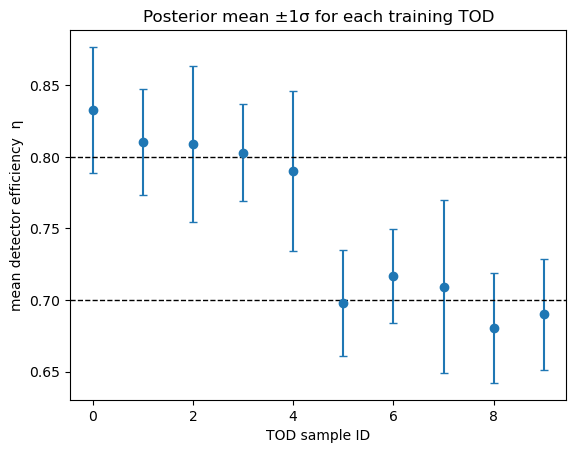

In [98]:
for i,(m,s) in enumerate(zip(eta_mean, eta_std)):
    print(f"SAMPLE {i:2d}  η = {m:.3f} ± {s:.3f}")

plt.errorbar(range(N), eta_mean, yerr=eta_std,
             fmt='o', capsize=3, color='tab:blue')
#plt.axhline(0.7, ls='--', c='k', lw=1)
plt.axhline(0.8, ls='--', c='k', lw=1)
plt.axhline(0.7, ls='--', c='k', lw=1)

plt.ylabel("mean detector efficiency  η")
plt.xlabel("TOD sample ID")
#plt.ylim(0.6, 1.0)
plt.title("Posterior mean ±1σ for each training TOD"); plt.show()

This is enough to get a mean efficiency and the error.
To look at the posterior and interpret it we need to draw samples.

# Drawing samples

In [101]:
def posterior_mean_std_and_samples(model, guide, det_tod, transmission,
                                   n_draw=60, chunk=10,
                                   sample_site="log_eta",
                                   keep_draws=False):
    """
    Same as before, but optionally returns a tensor of all stored draws.
    Set keep_draws=True if you want to keep them (this may be large! depends on the choice of size of sempling sets!).
    """
    assert n_draw % chunk == 0
    mean = m2 = None
    n_seen = 0
    all_draws = [] if keep_draws else None

    pred = Predictive(model, guide=guide, num_samples=chunk,
                      return_sites=[sample_site])

    for _ in range(n_draw // chunk):
        post   = pred(det_tod, transmission, sky=None)
        draws  = torch.exp(post[sample_site]).mean(1)   # (chunk, N_det)

        if keep_draws:
            all_draws.append(draws.cpu())              

        for x in draws:
            n_seen += 1
            if mean is None:
                mean = torch.zeros_like(x)
                m2   = torch.zeros_like(x)
            delta = x - mean
            mean += delta / n_seen
            m2   += delta * (x - mean)

        del post, draws

    std = torch.sqrt(m2 / (n_seen - 1))
    if keep_draws:
        all_draws = torch.cat(all_draws, dim=0)   # (n_draw, N_det)
        return mean.cpu(), std.cpu(), all_draws
    return mean.cpu(), std.cpu()


In [104]:
eta_mean, eta_std, eta_samples = posterior_mean_std_and_samples(
        model, guide, det_tod, q.optics.components['transmission'],
        n_draw=300, chunk=10, keep_draws=True)

In [105]:
if False:
    predictive  = Predictive(model, guide=guide, num_samples=50,
                            return_sites=["log_eta"])
    post         = predictive(det_tod, sky=None)
    eta_samples  = torch.exp(post["log_eta"])            # (300 , N)

    eta_mean = eta_samples.mean(0).cpu()                 # (N,)
    eta_std  = eta_samples.std (0).cpu()

In [106]:
from scipy.stats import norm

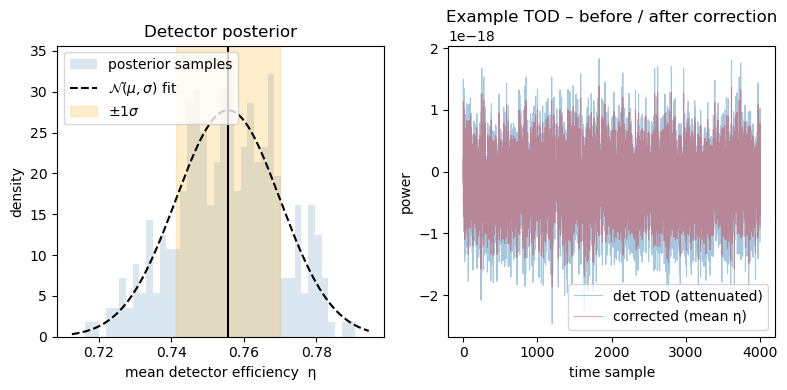

In [ ]:

# we hope to get 0.75 for a mix of 0.8 and 0.7
det_id = 0                       

invT_det = eta_samples[:,].cpu()        #,)

# posterior mean / std for this detector
mu_det  = eta_samples.mean().item()
sig_det = eta_samples.std().item()


tod_det   = det_tod[0, det_id].cpu()              # shape (Nt,)
tod_corr  = tod_det * mu_det                      # a point-estimate correction
tod_true  = sky_tod[0, det_id].cpu()

Nt = tod_det.numel()
t  = np.arange(Nt)                                # over time samples


fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(eta_samples[:].numpy(), bins=40, alpha=0.2,
               color='steelblue', density=True, label = 'posterior samples')

xmin, xmax = ax[0].get_xlim()
xs = np.linspace(xmin, xmax, 200)
ax[0].plot(xs, norm.pdf(xs, mu_det, sig_det), 'k--',
           label=r'$\mathcal{N}(\mu,\sigma)$ fit')
ax[0].axvline(mu_det, color='k')
ax[0].axvspan(mu_det - sig_det, mu_det + sig_det,
              alpha=0.2, color='orange', label=r'$\pm1\sigma$')
ax[0].set_xlabel(r'mean detector efficiency  η')
ax[0].set_ylabel('density')
ax[0].set_title(f'Detector posterior')
ax[0].legend()

ax[1].plot(t, tod_det,        lw=0.8, label='det TOD (attenuated)', alpha = 0.4)
ax[1].plot(t, tod_corr,       lw=0.8, label='corrected (mean η)', color='C3', alpha = 0.4)
#ax[1].plot(t, tod_true, '--', lw=1.0, label='sky TOD (target)',  color='k', alpha = 0.4)
ax[1].set_xlabel('time sample')
ax[1].set_ylabel('power')
ax[1].set_title('Example TOD – before / after correction')
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import os, numpy as np
import torch, pyro, pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam

pyro.set_rng_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

det_tod = tod_after_transmission_torch.to(torch.float32).to(device)  # (N, D, Nt)
sky_tod =  tod_before_transmission_torch.to(torch.float32).to(device) # (N, D, Nt)
N, D, Nt = det_tod.shape

trans_components = np.asarray(q.optics.components['transmission'], dtype=float)
t0 = float(np.prod(trans_components))  # the tru value will be used as prior

sigma_noise  = 1e-18                       # white noise  on TOD
sigma_eta    = 0.20                        # 20% on eta
sigma_topt   = 0.20                        # 20% also on the optics

class InvThroughput(torch.nn.Module):
    def forward(self, tod_det, eta, t_optics):
        return tod_det / (t_optics * eta[:, None, None])

layer = InvThroughput().to(device)

def model(det, sky):
    log_topt = pyro.sample("log_topt", dist.Normal(np.log(t0), sigma_topt))
    t_optics = torch.exp(log_topt)

    with pyro.plate("batch", det.size(0)):
        log_eta = pyro.sample("log_eta", dist.Normal(0.0, sigma_eta))
        eta = torch.exp(log_eta)

        sky_hat = layer(det, eta, t_optics)
        pyro.sample("obs", dist.Normal(sky_hat, sigma_noise).to_event(2), obs=sky)

guide = pyro.infer.autoguide.AutoNormal(model)

optim  = Adam({"lr": 3e-3})         

svi   = SVI(model, guide, optim, Trace_ELBO())

ckpt_file = "inv_eta_topt.ckpt"
start = 0
save_every = 10
n_steps = 400

if os.path.exists(ckpt_file):
    ckpt = torch.load(ckpt_file, map_location=device)
    pyro.get_param_store().set_state(ckpt["param_store"])
    optim.set_state(ckpt["optim_state"])
    start = ckpt["step"] + 1
    print(f"✓ Resuming from step {start}")

for step in range(start, start + n_steps):
    loss = svi.step(det_tod, sky_tod)

    if step % save_every == 0:
        torch.save(
            {
                "step":        step,
                "param_store": pyro.get_param_store().get_state(),
                "optim_state": optim.get_state(),
            },
            ckpt_file,
        )
        print(f"step {step:5d} | ELBO {loss:8.3g}  ➜ checkpoint saved")

print("Done ✔")


predictive = Predictive(model, guide=guide, num_samples=50,
                        return_sites=["log_eta", "log_topt"])
post       = predictive(det_tod, sky=None)

eta_samples   = torch.exp(post["log_eta"])     
topt_samples  = torch.exp(post["log_topt"])    

eta_mean = eta_samples.mean(0).cpu()          
eta_std  = eta_samples.std (0).cpu()
topt_mean = topt_samples.mean(0).cpu()         
topt_std  = topt_samples.std (0).cpu()


step     0 | ELBO -1.54e+09  ➜ checkpoint saved
step    10 | ELBO -1.53e+09  ➜ checkpoint saved
Done ✔


: 